In [81]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from pyproj import Transformer
from shapely import centroid
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from matplotlib.patches import FancyArrowPatch


In [82]:
admin_map_path = '/Users/simonirmer/Documents/Privat/Uni/Berlin/WS23-24/OR-INF/term_paper/operations_oppenheimer/data/vg2500_12-31.utm32s.shape/vg2500/VG2500_KRS.shp'
admin_map_path_2 = '/Users/simonirmer/Documents/Privat/Uni/Berlin/WS23-24/OR-INF/term_paper/operations_oppenheimer/data/vg2500_12-31.utm32s.shape/vg2500/VG2500_RBZ.shp'
excel_path = '/Users/simonirmer/Documents/Privat/Uni/Berlin/WS23-24/OR-INF/term_paper/operations_oppenheimer/data/ExtendedNuclearData.xlsx'
distance_sheet = "Transport"
final_storage_sheet = "End Storage"
cost_factor = 75
nuclear_factor = 100
cost_factor *= nuclear_factor

# read admin area df
krs_area_df = gpd.read_file(admin_map_path)
rbz_area_df = gpd.read_file(admin_map_path_2)

# remove cities
# admin_area_df = admin_area_df[(admin_area_df.BEZ.isin(['Kreis', 'Landkreis'])) & (admin_area.SN_L.isin(['01', ]))]
# krs_area_df = krs_area_df[(krs_area_df.BEZ.isin(['Kreis', 'Landkreis'])) & (~krs_area_df.SN_L.isin(rbz_area_df.SN_L.values))]
# admin_area_df = pd.concat([krs_area_df, rbz_area_df], ignore_index=True)

admin_area_df = rbz_area_df
# Define the UTM32 and WGS84 projections
utm32_crs = "EPSG:32632"  # UTM zone 32N
wgs84_crs = "EPSG:4326"   # WGS 84

# Create a transformer object
transformer = Transformer.from_crs(utm32_crs, wgs84_crs)

# Function to transform geometries
def transform_geometry(geom):
    if geom.geom_type == 'Point':
        x, y = transformer.transform(geom.x, geom.y)
        return Point(x, y)
    elif geom.geom_type == 'Polygon':
        exterior = [transformer.transform(x, y) for x, y in geom.exterior.coords]
        interiors = [[transformer.transform(x, y) for x, y in interior.coords] for interior in geom.interiors]
        return Polygon(exterior, interiors)
    elif geom.geom_type == 'MultiPolygon':
        transformed_polygons = []
        for poly in geom.geoms:
            exterior = [transformer.transform(x, y) for x, y in poly.exterior.coords]
            interiors = [[transformer.transform(x, y) for x, y in interior.coords] for interior in poly.interiors]
            transformed_polygons.append(Polygon(exterior, interiors))
        return MultiPolygon(transformed_polygons)
    else:
        raise TypeError(f"Geometry type '{geom.geom_type}' not supported")

# Apply the transformation to the geometry column
admin_area_df['geometry'] = admin_area_df['geometry'].apply(transform_geometry)

# calculate centroids of geometries
admin_area_df["centroids"] = admin_area_df.geometry.apply(lambda x: centroid(x))

### add coordinates of reactors / ISF
# geo coordinates for each interim storage facility
isf_coords = {"Gorleben": Point(53.033344625111255, 11.341597461918763),
              "Ahaus": Point(52.075884172859716, 7.056252098203471),
              "Brokdorf": Point(53.85053568702555, 9.345557443628627),
              "Brunsbüttel": Point(53.891632640377, 9.20050890913132),
              "Biblis": Point(49.70830596704328, 8.411540078513102),
              "Grafenrheinfeld": Point(49.98379398601132, 10.1866276073602),
              "Grohnde": Point(52.03567047221345, 9.41068601909146),
              "Grundemmingen": Point(48.51666979391695, 10.403076045930131),
              "Isar": Point(48.6075745368956, 12.291958334289768),
              "Lingen": Point(52.47033938642687, 7.321564619110349),
              "Krümmel": Point(53.410146129098514, 10.410102309356501),
              "Neckarwestheim": Point(49.0420294948931, 9.173420061294042),
              "Philippsburg": Point(49.25285028023963, 8.441867563151883),
              "Unterweser": Point(53.430121612826966, 8.476324972847728),
              "Lubmin": Point(54.14141668772474, 13.677069821066244)}


# transform regional data in dict format
admin_coords = {k:v for k, v in zip(admin_area_df["GEN"], admin_area_df["centroids"])}


combined_coords = isf_coords | admin_coords

# add hot cell locations
hot_cell_coords = {"HC " + k: v for k, v in combined_coords.items()}
combined_coords = combined_coords | hot_cell_coords
combined_coords = {k: (v.x, v.y) for k, v in combined_coords.items()}

In [83]:
row_list = []
for n, c in combined_coords.items():
    d = {}
    d["name"] = n
    d["latitude"] = c[0]
    d["longitude"] = c[1]
    row_list.append(d)
coords_df = pd.DataFrame(row_list)

In [133]:
geometry = [Point(xy) for xy in zip(coords_df['longitude'], coords_df['latitude'])]
coords_gdf = GeoDataFrame(coords_df, geometry=geometry)
ger = gpd.read_file("/Users/simonirmer/Documents/Privat/Uni/Berlin/WS23-24/OR-INF/term_paper/operations_oppenheimer/data/vg2500_geo84/vg2500_krs.shp")

In [134]:
snf_path = "/Users/simonirmer/Documents/Privat/Uni/Berlin/WS23-24/OR-INF/term_paper/operations_oppenheimer/snf_stored.csv"
nc_path = "/Users/simonirmer/Documents/Privat/Uni/Berlin/WS23-24/OR-INF/term_paper/operations_oppenheimer/nc_stored.csv"
snf_init = pd.read_excel("/Users/simonirmer/Documents/Privat/Uni/Berlin/WS23-24/OR-INF/term_paper/operations_oppenheimer/data/ExtendedNuclearData.xlsx", sheet_name="Reactors")
snf_init

,name,snf,capacity,costs
0,Ahaus,56,370,2000
1,Brokdorf,50,100,2000
2,Gorleben,113,420,2000
3,Brunsbüttel,24,20,2000
4,Biblis,108,135,2000
5,Grafenrheinfeld,54,88,2000
6,Grohnde,51,100,2000
7,Grundemmingen,127,192,2000
8,Isar,88,152,2000
9,Lingen,47,125,2000


In [135]:
marker_sizes = []
cisf_list = []

snf_stored = pd.read_csv(snf_path)
nc_stored = pd.read_csv(nc_path)
init_values = []
for row in snf_init.iterrows():
    init_values.append({"node": row[1]["name"],
                    "year": 2029,
                    "SNF": row[1]["snf"]})
snf_stored = pd.concat([snf_stored, pd.DataFrame(init_values)], ignore_index=True)

snf_sizes = [snf_stored[(snf_stored.year == 2030) & (snf_stored.node == n)]["SNF"].values[0] if n in snf_stored.node.unique() else 0 for n in combined_coords.keys()]
nc_sizes = [nc_stored[(nc_stored.year == 2030) & (nc_stored.node == n)]["NC"].values[0] if n in nc_stored.node.unique() else 0 for n in combined_coords.keys()]
marker_sizes.append([x+y for x,y in zip(snf_sizes, nc_sizes)])

cisf_list.append(nc_stored[(nc_stored.year == 2031) & (nc_stored.NC > 0)].node)

In [136]:
snf_t_path = "/Users/simonirmer/Documents/Privat/Uni/Berlin/WS23-24/OR-INF/term_paper/operations_oppenheimer/snf_shipped.csv"
nc_t_path = "/Users/simonirmer/Documents/Privat/Uni/Berlin/WS23-24/OR-INF/term_paper/operations_oppenheimer/nc_shipped.csv"

In [137]:
snf_t_df = pd.read_csv(snf_t_path)
nc_t_df = pd.read_csv(nc_t_path)

In [138]:
# Merge the two DataFrames, filling missing columns with 0
combined_df = pd.merge(snf_t_df, nc_t_df, on=['from', 'to', 'year'], how='outer').fillna(0)

# If SNF or NC are not present, replace missing values with 0
combined_df['SNF'] = combined_df['SNF'].fillna(0)
combined_df['NC'] = combined_df['NC'].fillna(0)

# Create a new column 'Total' that sums SNF and NC
combined_df['Total'] = combined_df['SNF'] + combined_df['NC']

In [139]:
# If SNF or NC are not present, replace missing values with 0
combined_df['SNF'] = combined_df['SNF'].fillna(0)
combined_df['NC'] = combined_df['NC'].fillna(0)

# Create a new column 'Total' that sums SNF and NC
combined_df['Total'] = combined_df['SNF'] + combined_df['NC']

In [140]:
# Group by 'from' and 'to' and sum the 'Total' values
result_df = combined_df.groupby(['from', 'to'], as_index=False).agg({'SNF': 'sum', 'NC': 'sum', 'Total': 'sum'})

# Display the result
print(result_df)

            from            to  SNF   NC  Total
0          Ahaus         Ahaus  0.0  0.0    0.0
1          Ahaus      Arnsberg  0.0  0.0    0.0
2          Ahaus        Biblis  0.0  0.0    0.0
3          Ahaus      Brokdorf  0.0  0.0    0.0
4          Ahaus   Brunsbüttel  0.0  0.0    0.0
...          ...           ...  ...  ...    ...
4619  Unterweser      Schwaben  0.0  0.0    0.0
4620  Unterweser     Stuttgart  0.0  0.0    0.0
4621  Unterweser      Tübingen  0.0  0.0    0.0
4622  Unterweser  Unterfranken  0.0  0.0    0.0
4623  Unterweser    Unterweser  0.0  0.0    0.0

[4624 rows x 5 columns]


In [141]:
# Calculate the total flow (incoming + outgoing) for each node for SNF, NC, and Total
outgoing_snf = result_df.groupby('from')['SNF'].sum().rename("outgoing_snf")
incoming_snf = result_df.groupby('to')['SNF'].sum().rename("incoming_snf")
outgoing_nc = result_df.groupby('from')['NC'].sum().rename("outgoing_nc")
incoming_nc = result_df.groupby('to')['NC'].sum().rename("incoming_nc")
outgoing_total = result_df.groupby('from')['Total'].sum().rename("outgoing_total")
incoming_total = result_df.groupby('to')['Total'].sum().rename("incoming_total")

In [142]:
# Merge these totals with the coordinates GeoDataFrame
coords_gdf = coords_gdf.set_index('name')
coords_gdf = coords_gdf.join(outgoing_snf, how='left').join(incoming_snf, how='left')
coords_gdf = coords_gdf.join(outgoing_nc, how='left').join(incoming_nc, how='left')
coords_gdf = coords_gdf.join(outgoing_total, how='left').join(incoming_total, how='left')


In [143]:
# Replace NaN values with 0 for nodes with no incoming or outgoing flow
coords_gdf = coords_gdf.fillna(0)

# Calculate the total flow (incoming + outgoing) for SNF, NC, and Total
coords_gdf['total_snf'] = coords_gdf['outgoing_snf'] + coords_gdf['incoming_snf']
coords_gdf['total_nc'] = coords_gdf['outgoing_nc'] + coords_gdf['incoming_nc']
coords_gdf['total_flow'] = coords_gdf['outgoing_total'] + coords_gdf['incoming_total']

In [144]:
# Merge to get 'from' and 'to' coordinates
merged_df = result_df.merge(coords_gdf, left_on='from', right_index=True)
merged_df = merged_df.rename(columns={'geometry': 'from_geometry'})
merged_df = merged_df.merge(coords_gdf, left_on='to', right_index=True, suffixes=('_from', '_to'))


In [145]:
# Merge the coordinates back with the result_df to get 'from' and 'to' geometries
merged_df = result_df.merge(coords_gdf[['geometry']], left_on='from', right_index=True)
merged_df = merged_df.rename(columns={'geometry': 'from_geometry'})
merged_df = merged_df.merge(coords_gdf[['geometry']], left_on='to', right_index=True)
merged_df = merged_df.rename(columns={'geometry': 'to_geometry'})

In [146]:
# Create LineString geometries
merged_df['line'] = merged_df.apply(lambda row: LineString([row['from_geometry'], row['to_geometry']]), axis=1)
lines_gdf = gpd.GeoDataFrame(merged_df, geometry='line')

In [147]:
# filter gdf such that only used nodes are included
lines_gdf = lines_gdf[lines_gdf.Total > 0]
coords_gdf = coords_gdf[coords_gdf.index.isin(lines_gdf["from"]) | coords_gdf.index.isin(lines_gdf["to"])]
# Assign colors based on whether the name starts with "HC "
coords_gdf['color'] = coords_gdf.index.to_series().apply(lambda x: 'blue' if x.startswith('HC ') else 'red')


In [148]:
coords_gdf

,latitude,longitude,geometry,outgoing_snf,incoming_snf,outgoing_nc,incoming_nc,outgoing_total,incoming_total,total_snf,total_nc,total_flow,color
name,,,,,,,,,,,,,
Gorleben,53.033345,11.341597,POINT (11.3416 53.03334),113.0,0.0,0.0,0.0,113.0,0.0,113.0,0.0,113.0,red
Ahaus,52.075884,7.056252,POINT (7.05625 52.07588),56.0,0.0,0.0,0.0,56.0,0.0,56.0,0.0,56.0,red
Brokdorf,53.850536,9.345557,POINT (9.34556 53.85054),54.0,4.0,0.0,0.0,54.0,4.0,58.0,0.0,58.0,red
Brunsbüttel,53.891633,9.200509,POINT (9.20051 53.89163),24.0,0.0,0.0,0.0,24.0,0.0,24.0,0.0,24.0,red
Biblis,49.708306,8.411540,POINT (8.41154 49.70831),108.0,0.0,0.0,0.0,108.0,0.0,108.0,0.0,108.0,red
Grafenrheinfeld,49.983794,10.186628,POINT (10.18663 49.98379),54.0,0.0,0.0,0.0,54.0,0.0,54.0,0.0,54.0,red
Grohnde,52.035670,9.410686,POINT (9.41069 52.03567),51.0,0.0,0.0,0.0,51.0,0.0,51.0,0.0,51.0,red
Grundemmingen,48.516670,10.403076,POINT (10.40308 48.51667),127.0,0.0,0.0,0.0,127.0,0.0,127.0,0.0,127.0,red
Isar,48.607575,12.291958,POINT (12.29196 48.60757),88.0,0.0,0.0,0.0,88.0,0.0,88.0,0.0,88.0,red


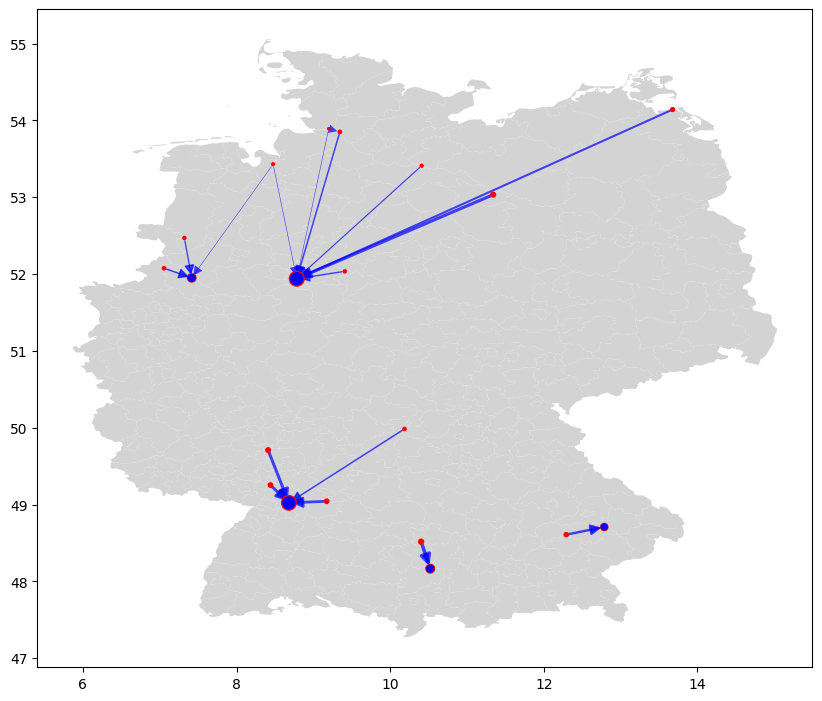

In [150]:
# Plot the map and nodes
fig, ax = plt.subplots(figsize=(10, 10))
ger.plot(ax=ax, color='lightgrey')

# Function to plot arrows for lines indicating direction
def plot_arrow(line, ax, color='blue', lw=1.5, alpha=0.7):
    if lw > 0:  # Only plot if linewidth is greater than 0
        x_start, y_start = line.coords[0]
        x_end, y_end = line.coords[1]

        arrow = FancyArrowPatch((x_start, y_start), (x_end, y_end), color=color, 
                                arrowstyle='-|>', mutation_scale=15, lw=lw, alpha=alpha)
        ax.add_patch(arrow)

# Plot each line with arrows indicating direction
for _, row in lines_gdf.iterrows():
    line_width = row['Total'] / 50  # Calculate the linewidth based on Total flow
    plot_arrow(row['line'], ax, lw=line_width)  # Only plot if line_width > 0

# Plot the nodes with size based on total SNF, NC, and Total flow
# Here, we plot the total flow. Adjust markersize as needed for SNF or NC.
coords_gdf.plot(ax=ax, color=coords_gdf["color"], markersize=coords_gdf['total_flow'] / 10, zorder=3)

# Annotate the nodes
# for x, y, label in zip(coords_gdf.geometry.x, coords_gdf.geometry.y, coords_gdf.index):
#     ax.text(x, y, label, fontsize=12, ha='right')

plt.show()

In [67]:
# filter gdf such that only used nodes are included
gdf = gdf[gdf["name"].isin(lines_gdf["from"]) | gdf["name"].isin(lines_gdf["to"])]

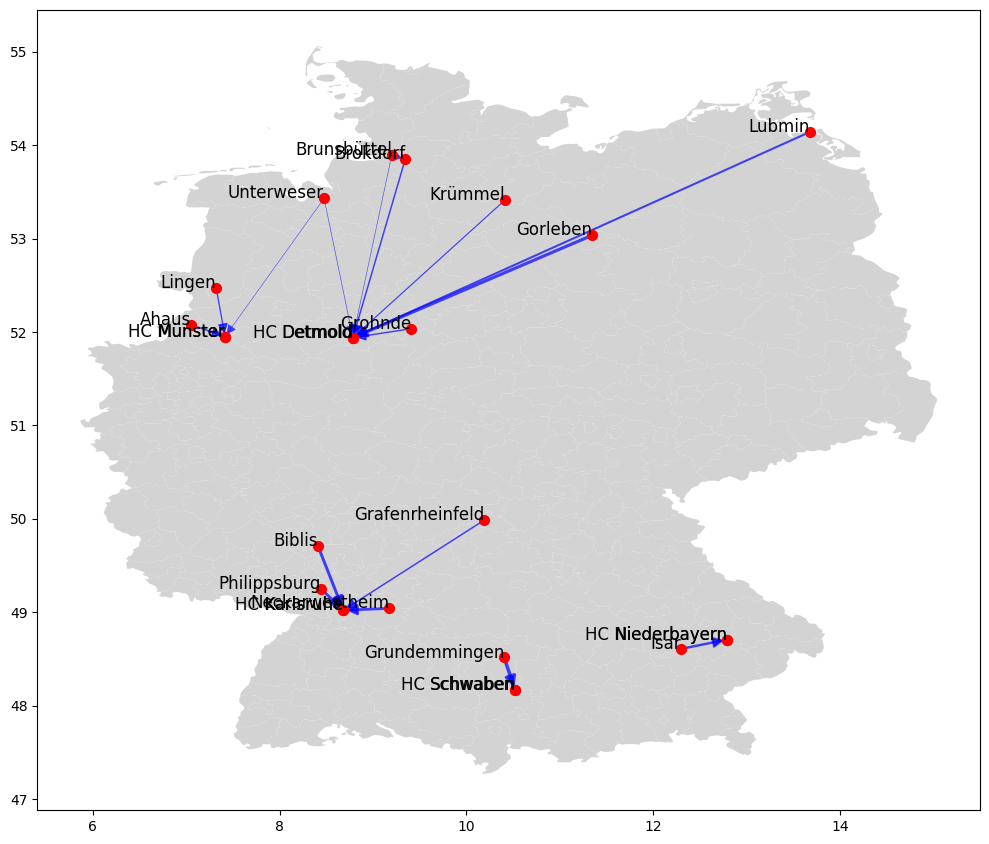

In [77]:
# Plot the map and nodes
fig, ax = plt.subplots(figsize=(10, 10))
ger.plot(ax=ax, color='lightgrey', aspect=1.4)

# Set the aspect ratio
#ax.set_aspect("equal")

# Plot the nodes
gdf.plot(ax=ax, color='red', markersize=50, zorder=3)

# Function to plot arrows for lines indicating direction
def plot_arrow(line, ax, color='blue', lw=1.5, alpha=0.7):
    if lw > 0:  # Only plot if linewidth is greater than 0
        x_start, y_start = line.coords[0]
        x_end, y_end = line.coords[1]

        arrow = FancyArrowPatch((x_start, y_start), (x_end, y_end), color=color, 
                                arrowstyle='-|>', mutation_scale=15, lw=lw, alpha=alpha)
        ax.add_patch(arrow)

# Plot each line with arrows indicating direction
for _, row in lines_gdf.iterrows():
    line_width = row['Total'] / 50  # Calculate the linewidth based on SNF
    plot_arrow(row['line'], ax, lw=line_width)  # Only plot if line_width > 0

# Annotate the nodes
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['name']):
    if label in lines_gdf["from"].values or label in lines_gdf["to"].values:
        ax.text(x, y, label, fontsize=12, ha='right')

plt.tight_layout()
plt.show()